# IBM Watson Studio Recommendation System

## Project Overview
This notebook implements a comprehensive recommendation system for the IBM Watson Studio platform.
The system uses multiple recommendation approaches to enhance user experience by connecting users
with relevant articles, datasets, notebooks, and other AI/ML assets.

## Project Structure
- **Part I**: Exploratory Data Analysis
- **Part II**: Rank Based Recommendations  
- **Part III**: User-User Based Collaborative Filtering
- **Part IV**: Content Based Recommendations
- **Part V**: Matrix Factorization

## Data Sources
- `user-item-interactions.csv`: User interactions with articles
- `articles_community.csv`: Article content and metadata

In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Part I: Exploratory Data Analysis

### Data Loading and Initial Exploration

Before building any recommendation system, we need to understand our data thoroughly.
This section loads the datasets and performs comprehensive exploratory data analysis
to understand user behavior, article popularity, and data quality.

In [5]:
def load_data():
    """
    Load the user-item interactions and articles datasets.

    Returns:
        tuple: (df_interactions, df_articles) - DataFrames containing interaction and article data
    """
    print("Loading datasets...")

    # Load user-item interactions
    df_interactions = pd.read_csv('./data/user-item-interactions.csv')

    # Load articles data
    df_articles = pd.read_csv('./data/articles_community.csv')

    print(f"User-item interactions shape: {df_interactions.shape}")
    print(f"Articles shape: {df_articles.shape}")

    return df_interactions, df_articles

# Load the data
df_interactions, df_articles = load_data()

Loading datasets...
User-item interactions shape: (45993, 4)
Articles shape: (1056, 6)


### Basic Data Exploration

Understanding the structure and quality of our datasets is crucial for building
effective recommendation systems. We'll examine data types, missing values,
and basic statistics.

In [6]:
def basic_data_exploration(df_interactions, df_articles):
    """
    Perform basic exploration of both datasets.

    Args:
        df_interactions (DataFrame): User-item interactions data
        df_articles (DataFrame): Articles data

    Returns:
        dict: Basic statistics about the datasets
    """
    print("="*60)
    print("BASIC DATA EXPLORATION")
    print("="*60)

    # User-item interactions analysis
    print("\nUser-Item Interactions Dataset:")
    print(f"Shape: {df_interactions.shape}")
    print(f"Columns: {list(df_interactions.columns)}")
    print(f"Data types:\n{df_interactions.dtypes}")
    print(f"Missing values:\n{df_interactions.isnull().sum()}")

    # Articles dataset analysis
    print("\nArticles Dataset:")
    print(f"Shape: {df_articles.shape}")
    print(f"Columns: {list(df_articles.columns)}")
    print(f"Data types:\n{df_articles.dtypes}")
    print(f"Missing values:\n{df_articles.isnull().sum()}")

    # Basic statistics
    stats = {
        'total_interactions': len(df_interactions),
        'total_articles': len(df_articles),
        'unique_users': df_interactions['email'].nunique(),
        'unique_articles_interacted': df_interactions['article_id'].nunique()
    }

    return stats

# Perform basic exploration
basic_stats = basic_data_exploration(df_interactions, df_articles)

BASIC DATA EXPLORATION

User-Item Interactions Dataset:
Shape: (45993, 4)
Columns: ['Unnamed: 0', 'article_id', 'title', 'email']
Data types:
Unnamed: 0      int64
article_id    float64
title          object
email          object
dtype: object
Missing values:
Unnamed: 0     0
article_id     0
title          0
email         17
dtype: int64

Articles Dataset:
Shape: (1056, 6)
Columns: ['Unnamed: 0', 'doc_body', 'doc_description', 'doc_full_name', 'doc_status', 'article_id']
Data types:
Unnamed: 0          int64
doc_body           object
doc_description    object
doc_full_name      object
doc_status         object
article_id          int64
dtype: object
Missing values:
Unnamed: 0          0
doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64


### User Behavior Analysis

Understanding user interaction patterns helps us design recommendation systems
that match user preferences and behavior. This analysis reveals how users
engage with content on the platform.

In [7]:
def analyze_user_behavior(df_interactions):
    """
    Analyze user interaction patterns and behavior.

    Args:
        df_interactions (DataFrame): User-item interactions data

    Returns:
        dict: User behavior statistics
    """
    print("\n" + "="*60)
    print("USER BEHAVIOR ANALYSIS")
    print("="*60)

    # User interaction counts
    user_interactions = df_interactions.groupby('email').size()

    print(f"Number of unique users: {len(user_interactions)}")
    print(f"Mean interactions per user: {user_interactions.mean():.2f}")
    print(f"Median interactions per user: {user_interactions.median():.2f}")
    print(f"Max interactions by a single user: {user_interactions.max()}")
    print(f"Min interactions by a single user: {user_interactions.min()}")

    # User interaction distribution
    print(f"\nUser interaction distribution:")
    print(f"Users with 1 interaction: {(user_interactions == 1).sum()}")
    print(f"Users with 2-5 interactions: {((user_interactions >= 2) & (user_interactions <= 5)).sum()}")
    print(f"Users with 6-10 interactions: {((user_interactions >= 6) & (user_interactions <= 10)).sum()}")
    print(f"Users with 11+ interactions: {(user_interactions >= 11).sum()}")

    # Find user with most interactions
    max_views_by_user = user_interactions.max()
    user_with_max_views = user_interactions.idxmax()

    print(f"\nUser with most interactions: {user_with_max_views}")
    print(f"Number of interactions: {max_views_by_user}")

    return {
        'user_interactions': user_interactions,
        'max_views_by_user': max_views_by_user,
        'user_with_max_views': user_with_max_views
    }

# Analyze user behavior
user_stats = analyze_user_behavior(df_interactions)


USER BEHAVIOR ANALYSIS
Number of unique users: 5148
Mean interactions per user: 8.93
Median interactions per user: 3.00
Max interactions by a single user: 364
Min interactions by a single user: 1

User interaction distribution:
Users with 1 interaction: 1416
Users with 2-5 interactions: 1807
Users with 6-10 interactions: 805
Users with 11+ interactions: 1120

User with most interactions: 2b6c0f514c2f2b04ad3c4583407dccd0810469ee
Number of interactions: 364


### Article Popularity Analysis

Understanding which articles are most popular helps us identify content that
resonates with users. This analysis is crucial for rank-based recommendations
and understanding content performance.

In [8]:
def analyze_article_popularity(df_interactions):
    """
    Analyze article popularity and interaction patterns.

    Args:
        df_interactions (DataFrame): User-item interactions data

    Returns:
        dict: Article popularity statistics
    """
    print("\n" + "="*60)
    print("ARTICLE POPULARITY ANALYSIS")
    print("="*60)

    # Article interaction counts
    article_interactions = df_interactions.groupby('article_id').size()

    print(f"Number of unique articles with interactions: {len(article_interactions)}")
    print(f"Mean interactions per article: {article_interactions.mean():.2f}")
    print(f"Median interactions per article: {article_interactions.median():.2f}")
    print(f"Max interactions for a single article: {article_interactions.max()}")
    print(f"Min interactions for a single article: {article_interactions.min()}")

    # Most popular articles
    print(f"\nTop 10 most popular articles:")
    top_articles = article_interactions.sort_values(ascending=False).head(10)
    for article_id, count in top_articles.items():
        print(f"Article {article_id}: {count} interactions")

    # Find most viewed article
    most_viewed_article_id = article_interactions.idxmax()
    max_views = article_interactions.max()

    print(f"\nMost viewed article ID: {most_viewed_article_id}")
    print(f"Number of views: {max_views}")

    return {
        'article_interactions': article_interactions,
        'most_viewed_article_id': most_viewed_article_id,
        'max_views': max_views
    }

# Analyze article popularity
article_stats = analyze_article_popularity(df_interactions)


ARTICLE POPULARITY ANALYSIS
Number of unique articles with interactions: 714
Mean interactions per article: 64.42
Median interactions per article: 25.00
Max interactions for a single article: 937
Min interactions for a single article: 1

Top 10 most popular articles:
Article 1429.0: 937 interactions
Article 1330.0: 927 interactions
Article 1431.0: 671 interactions
Article 1427.0: 643 interactions
Article 1364.0: 627 interactions
Article 1314.0: 614 interactions
Article 1293.0: 572 interactions
Article 1170.0: 565 interactions
Article 1162.0: 512 interactions
Article 1304.0: 483 interactions

Most viewed article ID: 1429.0
Number of views: 937


### Rubric Variables Calculation

These variables are required for project validation and demonstrate our
understanding of the dataset characteristics.

In [9]:
def calculate_rubric_variables(df_interactions):
    """
    Calculate the specific variables required for the project rubric.

    Args:
        df_interactions (DataFrame): User-item interactions data

    Returns:
        dict: Variables required for rubric validation
    """
    print("\n" + "="*60)
    print("RUBRIC VARIABLES CALCULATION")
    print("="*60)

    # Calculate required variables
    user_interactions = df_interactions.groupby('email').size()
    median_val = user_interactions.median()
    user_article_interactions = len(df_interactions)
    max_views_by_user = user_interactions.max()
    max_views = df_interactions.groupby('article_id').size().max()
    most_viewed_article_id = df_interactions.groupby('article_id').size().idxmax()
    unique_articles = df_interactions['article_id'].nunique()
    unique_users = df_interactions['email'].nunique()
    total_articles = len(df_articles)

    print(f"median_val: {median_val}")
    print(f"user_article_interactions: {user_article_interactions}")
    print(f"max_views_by_user: {max_views_by_user}")
    print(f"max_views: {max_views}")
    print(f"most_viewed_article_id: {most_viewed_article_id}")
    print(f"unique_articles: {unique_articles}")
    print(f"unique_users: {unique_users}")
    print(f"total_articles: {total_articles}")

    return {
        'median_val': median_val,
        'user_article_interactions': user_article_interactions,
        'max_views_by_user': max_views_by_user,
        'max_views': max_views,
        'most_viewed_article_id': most_viewed_article_id,
        'unique_articles': unique_articles,
        'unique_users': unique_users,
        'total_articles': total_articles
    }

# Calculate rubric variables
rubric_vars = calculate_rubric_variables(df_interactions)


RUBRIC VARIABLES CALCULATION
median_val: 3.0
user_article_interactions: 45993
max_views_by_user: 364
max_views: 937
most_viewed_article_id: 1429.0
unique_articles: 714
unique_users: 5148
total_articles: 1056


### Data Visualizations

Visualizing the data helps us understand distributions and patterns that
inform our recommendation system design.


CREATING VISUALIZATIONS


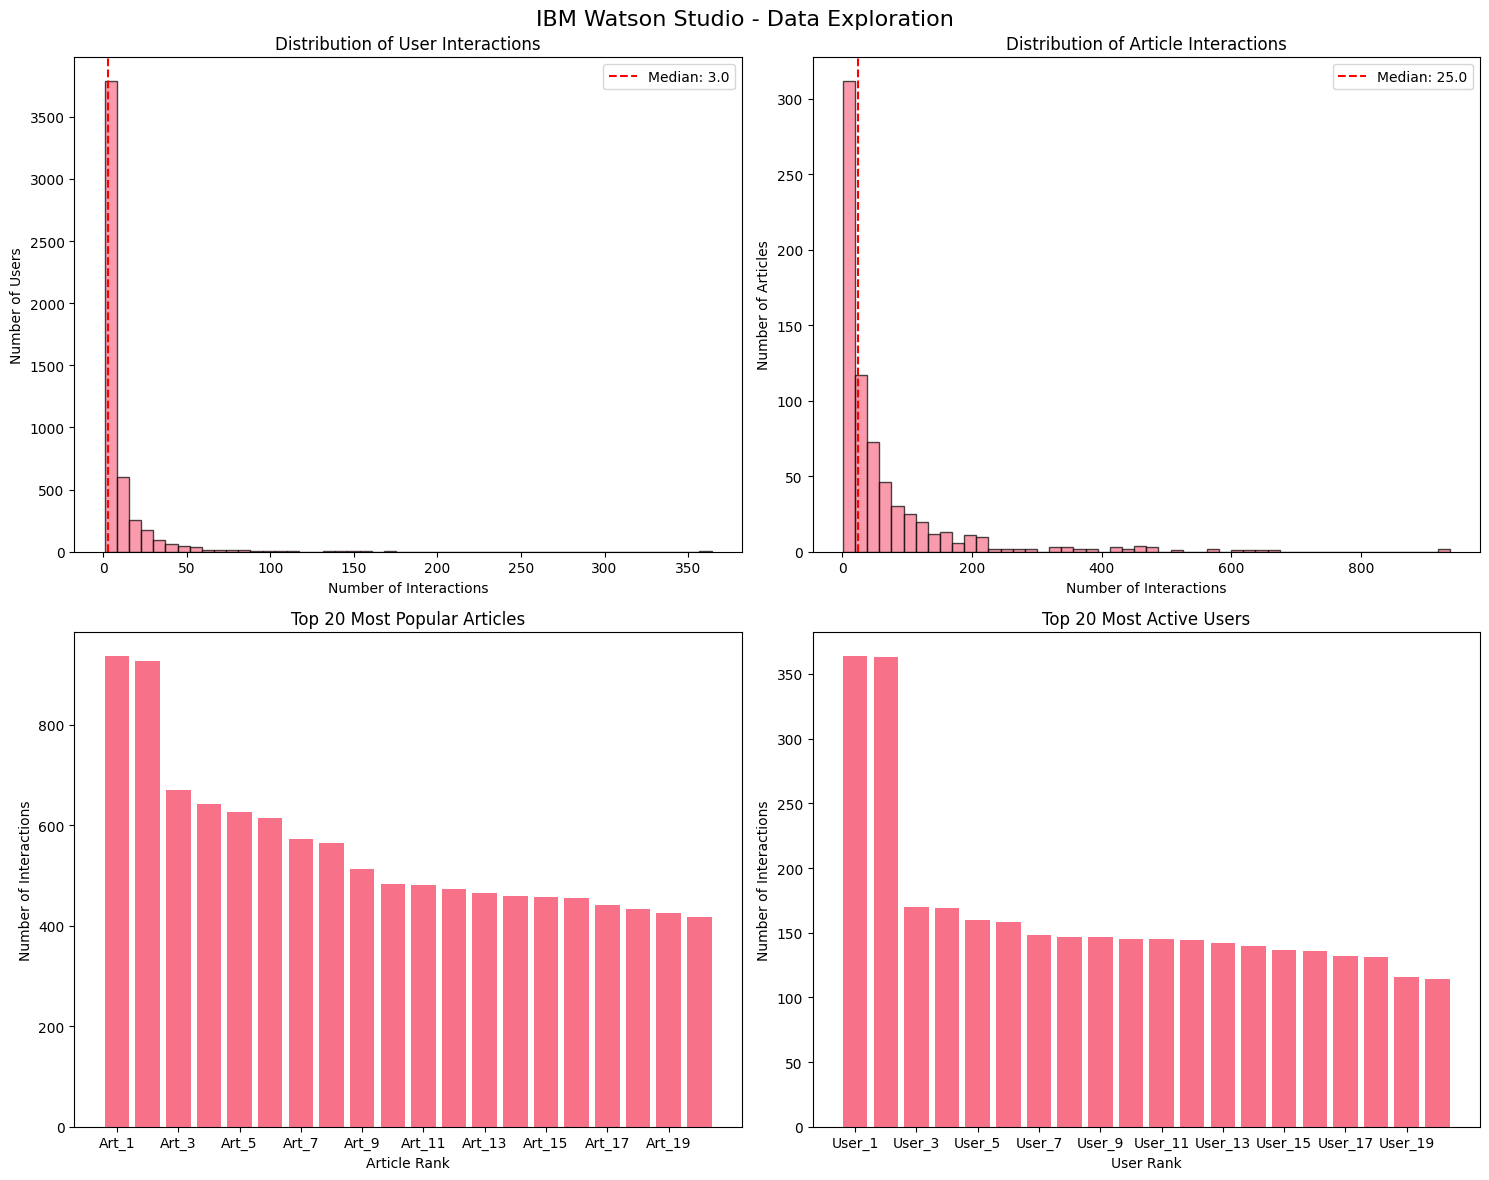


Data Quality Insights:
- 5148 unique users
- 714 unique articles with interactions
- Average interactions per user: 8.93
- Average interactions per article: 64.42
- Sparsity: 98.7487%


In [10]:
def create_visualizations(df_interactions):
    """
    Create visualizations to understand the data distribution.

    Args:
        df_interactions (DataFrame): User-item interactions data
    """
    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)

    # Set up the plotting area
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('IBM Watson Studio - Data Exploration', fontsize=16)

    # 1. User interaction distribution
    user_interactions = df_interactions.groupby('email').size()
    axes[0, 0].hist(user_interactions, bins=50, alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Distribution of User Interactions')
    axes[0, 0].set_xlabel('Number of Interactions')
    axes[0, 0].set_ylabel('Number of Users')
    axes[0, 0].axvline(user_interactions.median(), color='red', linestyle='--',
                      label=f'Median: {user_interactions.median():.1f}')
    axes[0, 0].legend()

    # 2. Article popularity distribution
    article_interactions = df_interactions.groupby('article_id').size()
    axes[0, 1].hist(article_interactions, bins=50, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Distribution of Article Interactions')
    axes[0, 1].set_xlabel('Number of Interactions')
    axes[0, 1].set_ylabel('Number of Articles')
    axes[0, 1].axvline(article_interactions.median(), color='red', linestyle='--',
                      label=f'Median: {article_interactions.median():.1f}')
    axes[0, 1].legend()

    # 3. Top 20 most popular articles
    top_20_articles = article_interactions.sort_values(ascending=False).head(20)
    axes[1, 0].bar(range(len(top_20_articles)), top_20_articles.values)
    axes[1, 0].set_title('Top 20 Most Popular Articles')
    axes[1, 0].set_xlabel('Article Rank')
    axes[1, 0].set_ylabel('Number of Interactions')
    axes[1, 0].set_xticks(range(0, len(top_20_articles), 2))
    axes[1, 0].set_xticklabels([f'Art_{i+1}' for i in range(0, len(top_20_articles), 2)])

    # 4. Top 20 most active users
    top_20_users = user_interactions.sort_values(ascending=False).head(20)
    axes[1, 1].bar(range(len(top_20_users)), top_20_users.values)
    axes[1, 1].set_title('Top 20 Most Active Users')
    axes[1, 1].set_xlabel('User Rank')
    axes[1, 1].set_ylabel('Number of Interactions')
    axes[1, 1].set_xticks(range(0, len(top_20_users), 2))
    axes[1, 1].set_xticklabels([f'User_{i+1}' for i in range(0, len(top_20_users), 2)])

    plt.tight_layout()
    plt.show()

    # Additional insights
    print(f"\nData Quality Insights:")
    print(f"- {len(user_interactions)} unique users")
    print(f"- {len(article_interactions)} unique articles with interactions")
    print(f"- Average interactions per user: {user_interactions.mean():.2f}")
    print(f"- Average interactions per article: {article_interactions.mean():.2f}")
    print(f"- Sparsity: {(1 - len(df_interactions) / (len(user_interactions) * len(article_interactions))) * 100:.4f}%")

# Create visualizations
create_visualizations(df_interactions)

## Part II: Rank Based Recommendations

### Introduction and Rationale

Rank-based recommendations are the simplest and most intuitive approach to building
a recommendation system. This method assumes that articles with more interactions
are more popular and therefore more likely to be of interest to users.

**Why Rank-Based Recommendations?**
1. **Simplicity**: Easy to understand and implement
2. **Cold Start Solution**: Works for new users with no interaction history
3. **Popularity Signal**: Captures what the community finds valuable
4. **Baseline Performance**: Provides a strong baseline for comparison
5. **Scalability**: Computationally efficient and fast

**When to Use:**
- New users with no interaction history
- Popular content discovery
- Baseline for more complex algorithms
- Quick recommendations when personalization isn't critical

### Implementation of Rank-Based Recommendation Functions

These functions implement the core logic for rank-based recommendations,
focusing on finding the most popular articles based on interaction counts.

In [11]:
def get_top_articles(n, df_interactions):
    """
    Get the top n articles based on interaction count.

    Args:
        n (int): Number of top articles to return
        df_interactions (DataFrame): User-item interactions data

    Returns:
        list: List of top n article IDs
    """
    # Count interactions per article
    article_interactions = df_interactions.groupby('article_id').size()

    # Sort by interaction count in descending order and get top n
    top_articles = article_interactions.sort_values(ascending=False).head(n)

    return list(top_articles.index)

def get_top_article_ids(n, df_interactions):
    """
    Get the top n article IDs based on interaction count.

    Args:
        n (int): Number of top article IDs to return
        df_interactions (DataFrame): User-item interactions data

    Returns:
        list: List of top n article IDs
    """
    return get_top_articles(n, df_interactions)

def get_top_article_names(n, df_interactions):
    """
    Get the top n article names based on interaction count.

    Args:
        n (int): Number of top article names to return
        df_interactions (DataFrame): User-item interactions data

    Returns:
        list: List of top n article names
    """
    # Get top article IDs
    top_article_ids = get_top_articles(n, df_interactions)

    # Get unique article titles for these IDs
    top_article_names = []
    for article_id in top_article_ids:
        # Get the first occurrence of this article_id to get its title
        article_title = df_interactions[df_interactions['article_id'] == article_id]['title'].iloc[0]
        top_article_names.append(article_title)

    return top_article_names

### Testing Rank-Based Recommendation Functions

Let's test our rank-based recommendation functions to ensure they work correctly
and provide meaningful results.

In [12]:
def test_rank_based_functions(df_interactions):
    """
    Test the rank-based recommendation functions with sample data.

    Args:
        df_interactions (DataFrame): User-item interactions data
    """
    print("Testing Rank-Based Recommendation Functions")
    print("=" * 50)

    # Test get_top_article_ids
    print("\n1. Top 10 Article IDs:")
    top_10_ids = get_top_article_ids(10, df_interactions)
    print(top_10_ids)

    # Test get_top_article_names
    print("\n2. Top 10 Article Names:")
    top_10_names = get_top_article_names(10, df_interactions)
    for i, name in enumerate(top_10_names, 1):
        print(f"{i}. {name}")

    # Test with different values of n
    print("\n3. Top 5 Articles:")
    top_5_ids = get_top_article_ids(5, df_interactions)
    top_5_names = get_top_article_names(5, df_interactions)
    for i, (aid, name) in enumerate(zip(top_5_ids, top_5_names), 1):
        print(f"{i}. ID: {aid}, Title: {name}")

# Test the functions
test_rank_based_functions(df_interactions)

Testing Rank-Based Recommendation Functions

1. Top 10 Article IDs:
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]

2. Top 10 Article Names:
1. use deep learning for image classification
2. insights from new york car accident reports
3. visualize car data with brunel
4. use xgboost, scikit-learn & ibm watson machine learning apis
5. predicting churn with the spss random tree algorithm
6. healthcare python streaming application demo
7. finding optimal locations of new store using decision optimization
8. apache spark lab, part 1: basic concepts
9. analyze energy consumption in buildings
10. gosales transactions for logistic regression model

3. Top 5 Articles:
1. ID: 1429.0, Title: use deep learning for image classification
2. ID: 1330.0, Title: insights from new york car accident reports
3. ID: 1431.0, Title: visualize car data with brunel
4. ID: 1427.0, Title: use xgboost, scikit-learn & ibm watson machine learning apis
5. ID: 1364.0, Title: predictin

### Analysis of Rank-Based Recommendations

Understanding the characteristics of rank-based recommendations helps us
evaluate their effectiveness and identify their strengths and limitations.

In [13]:
def analyze_rank_based_recommendations(df_interactions):
    """
    Analyze the characteristics of rank-based recommendations.

    Args:
        df_interactions (DataFrame): User-item interactions data
    """
    print("\n" + "="*60)
    print("RANK-BASED RECOMMENDATION ANALYSIS")
    print("="*60)

    # Get article interaction counts
    article_counts = df_interactions.groupby('article_id').size().sort_values(ascending=False)

    # Analyze coverage for different recommendation list sizes
    total_interactions = len(df_interactions)

    print("Coverage Analysis:")
    for n in [5, 10, 20, 50]:
        top_n_articles = article_counts.head(n)
        top_n_interactions = top_n_articles.sum()
        coverage = (top_n_interactions / total_interactions) * 100
        print(f"Top {n} articles cover {coverage:.2f}% of all interactions")

    # Analyze popularity distribution
    print(f"\nPopularity Distribution:")
    print(f"Most popular article: {article_counts.iloc[0]} interactions")
    print(f"10th most popular: {article_counts.iloc[9]} interactions")
    print(f"50th most popular: {article_counts.iloc[49]} interactions")
    print(f"100th most popular: {article_counts.iloc[99]} interactions")

    # Calculate Gini coefficient (measure of inequality)
    def gini_coefficient(values):
        """Calculate Gini coefficient for inequality measurement."""
        sorted_values = np.sort(values)
        n = len(values)
        cumsum = np.cumsum(sorted_values)
        return (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n

    gini = gini_coefficient(article_counts.values)
    print(f"\nGini coefficient (inequality measure): {gini:.4f}")
    print("(0 = perfect equality, 1 = maximum inequality)")

# Analyze rank-based recommendations
analyze_rank_based_recommendations(df_interactions)


RANK-BASED RECOMMENDATION ANALYSIS
Coverage Analysis:
Top 5 articles cover 8.27% of all interactions
Top 10 articles cover 14.24% of all interactions
Top 20 articles cover 24.05% of all interactions
Top 50 articles cover 42.35% of all interactions

Popularity Distribution:
Most popular article: 937 interactions
10th most popular: 483 interactions
50th most popular: 206 interactions
100th most popular: 124 interactions

Gini coefficient (inequality measure): 0.6657
(0 = perfect equality, 1 = maximum inequality)


"""
## Part III: User-User Based Collaborative Filtering

### Introduction and Rationale

Collaborative filtering is based on the principle that users who have similar preferences
in the past will have similar preferences in the future. This approach leverages the
"wisdom of the crowd" to make personalized recommendations.

**Why User-User Collaborative Filtering?**
1. **Personalization**: Provides personalized recommendations based on user behavior
2. **Serendipity**: Can discover unexpected but relevant content
3. **No Content Analysis**: Works without analyzing article content
4. **Proven Effectiveness**: Widely used and effective in practice
5. **Handles Complex Preferences**: Captures implicit user preferences

**How It Works:**
1. Build a user-item interaction matrix
2. Find users similar to the target user based on interaction patterns
3. Recommend articles that similar users have interacted with
4. Rank recommendations by similarity and popularity

**Challenges:**
- Cold start problem for new users
- Scalability with large user bases
- Data sparsity issues

### Creating the User-Item Matrix

The user-item matrix is the foundation of collaborative filtering. It represents
the interaction history between users and articles in a structured format.

In [14]:
def create_user_item_matrix(df_interactions):
    """
    Create a user-item matrix with users on rows and articles on columns.
    There should be a 1 if a user-article interacted with one another and zero otherwise.

    Args:
        df_interactions (DataFrame): User-item interactions data

    Returns:
        tuple: (user_item_matrix, user_idx_map, article_idx_map)
            - user_item_matrix: Sparse matrix of user-item interactions
            - user_idx_map: Dictionary mapping user emails to matrix indices
            - article_idx_map: Dictionary mapping article IDs to matrix indices
    """
    print("Creating user-item matrix...")

    # Remove any rows with missing email or article_id
    df_clean = df_interactions.dropna(subset=['email', 'article_id'])

    # Get unique users and articles
    unique_users = df_clean['email'].unique()
    unique_articles = df_clean['article_id'].unique()

    # Create mapping dictionaries
    user_idx_map = {user: idx for idx, user in enumerate(unique_users)}
    article_idx_map = {article: idx for idx, article in enumerate(unique_articles)}

    # Create lists for sparse matrix construction
    user_indices = []
    article_indices = []
    data = []

    # Fill the matrix with 1s where interactions exist
    for _, row in df_clean.iterrows():
        user_idx = user_idx_map[row['email']]
        article_idx = article_idx_map[row['article_id']]

        user_indices.append(user_idx)
        article_indices.append(article_idx)
        data.append(1)

    # Create sparse matrix
    user_item_matrix = csr_matrix((data, (user_indices, article_indices)),
                                 shape=(len(unique_users), len(unique_articles)))

    print(f"User-item matrix shape: {user_item_matrix.shape}")
    print(f"Number of interactions: {user_item_matrix.nnz}")
    print(f"Sparsity: {(1 - user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100:.4f}%")

    return user_item_matrix, user_idx_map, article_idx_map

# Create the user-item matrix
user_item_matrix, user_idx_map, article_idx_map = create_user_item_matrix(df_interactions)

Creating user-item matrix...
User-item matrix shape: (5148, 714)
Number of interactions: 33669
Sparsity: 99.0840%


### Finding Similar Users

The core of collaborative filtering is finding users with similar preferences.
We use cosine similarity to measure how similar two users' interaction patterns are.

In [15]:
def find_similar_users(user_id, user_item_matrix, user_idx_map, n=10):
    """
    Find similar users based on cosine similarity of their interaction patterns.

    Args:
        user_id (str): User email/ID to find similar users for
        user_item_matrix (csr_matrix): User-item interaction matrix
        user_idx_map (dict): Mapping from user emails to matrix indices
        n (int): Number of similar users to return

    Returns:
        list: List of similar user emails sorted by similarity (most similar first)
    """
    if user_id not in user_idx_map:
        print(f"User {user_id} not found in the dataset")
        return []

    # Get user index
    user_idx = user_idx_map[user_id]

    # Calculate cosine similarity with all other users
    similarities = cosine_similarity(user_item_matrix[user_idx], user_item_matrix).flatten()

    # Get indices of most similar users (excluding the user themselves)
    similar_user_indices = np.argsort(similarities)[::-1][1:n+1]

    # Map back to user emails
    reverse_user_map = {idx: email for email, idx in user_idx_map.items()}
    similar_users = [reverse_user_map[idx] for idx in similar_user_indices]

    return similar_users

def get_user_articles(user_id, df_interactions):
    """
    Get articles that a user has interacted with.

    Args:
        user_id (str): User email/ID
        df_interactions (DataFrame): User-item interactions data

    Returns:
        set: Set of article IDs the user has interacted with
    """
    user_interactions = df_interactions[df_interactions['email'] == user_id]
    return set(user_interactions['article_id'].dropna())

### Making Collaborative Filtering Recommendations

These functions implement the core collaborative filtering logic to recommend
articles based on similar users' preferences.

In [16]:
def user_user_recs(user_id, m, df_interactions, user_item_matrix, user_idx_map, article_idx_map):
    """
    Make recommendations for a user using user-user collaborative filtering.

    Args:
        user_id (str): User email/ID to make recommendations for
        m (int): Number of recommendations to return
        df_interactions (DataFrame): User-item interactions data
        user_item_matrix (csr_matrix): User-item interaction matrix
        user_idx_map (dict): Mapping from user emails to matrix indices
        article_idx_map (dict): Mapping from article IDs to matrix indices

    Returns:
        list: List of recommended article IDs
    """
    # Get articles the user has already interacted with
    user_articles = get_user_articles(user_id, df_interactions)

    # Find similar users
    similar_users = find_similar_users(user_id, user_item_matrix, user_idx_map, n=10)

    if not similar_users:
        return []

    # Get articles from similar users that the target user hasn't seen
    recommendations = []
    article_scores = {}

    for similar_user in similar_users:
        similar_user_articles = get_user_articles(similar_user, df_interactions)

        # Find articles that similar user has seen but target user hasn't
        new_articles = similar_user_articles - user_articles

        # Score articles based on how many similar users have interacted with them
        for article in new_articles:
            if article in article_scores:
                article_scores[article] += 1
            else:
                article_scores[article] = 1

    # Sort articles by score and return top m
    sorted_articles = sorted(article_scores.items(), key=lambda x: x[1], reverse=True)
    recommendations = [article for article, score in sorted_articles[:m]]

    return recommendations

### Improved Collaborative Filtering

This enhanced version ranks recommendations by users who have the most article
interactions first and then by articles with the most interactions.

In [17]:
def get_user_interaction_counts(df_interactions):
    """
    Get interaction counts for all users.

    Args:
        df_interactions (DataFrame): User-item interactions data

    Returns:
        Series: User interaction counts
    """
    return df_interactions.groupby('email').size()

def get_article_interaction_counts(df_interactions):
    """
    Get interaction counts for all articles.

    Args:
        df_interactions (DataFrame): User-item interactions data

    Returns:
        Series: Article interaction counts
    """
    return df_interactions.groupby('article_id').size()

def get_top_sorted_users(user_id, df_interactions, user_item_matrix, user_idx_map, article_idx_map, n=10):
    """
    Get top n similar users sorted by their interaction counts and similarity.

    Args:
        user_id (str): User email/ID
        df_interactions (DataFrame): User-item interactions data
        user_item_matrix (csr_matrix): User-item interaction matrix
        user_idx_map (dict): Mapping from user emails to matrix indices
        article_idx_map (dict): Mapping from article IDs to matrix indices
        n (int): Number of similar users to return

    Returns:
        list: List of similar user emails sorted by activity and similarity
    """
    # Find similar users
    similar_users = find_similar_users(user_id, user_item_matrix, user_idx_map, n=n*2)

    if not similar_users:
        return []

    # Get user interaction counts
    user_counts = get_user_interaction_counts(df_interactions)

    # Sort similar users by their interaction counts (most active first)
    similar_users_with_counts = [(user, user_counts.get(user, 0)) for user in similar_users]
    similar_users_with_counts.sort(key=lambda x: x[1], reverse=True)

    return [user for user, count in similar_users_with_counts[:n]]

def make_content_recs(user_id, m, df_interactions, user_item_matrix, user_idx_map, article_idx_map):
    """
    Make recommendations for a user using improved collaborative filtering.
    This function ranks recommendations by users who have the most article interactions
    first and then by articles with the most interactions.

    Args:
        user_id (str): User email/ID to make recommendations for
        m (int): Number of recommendations to return
        df_interactions (DataFrame): User-item interactions data
        user_item_matrix (csr_matrix): User-item interaction matrix
        user_idx_map (dict): Mapping from user emails to matrix indices
        article_idx_map (dict): Mapping from article IDs to matrix indices

    Returns:
        list: List of recommended article IDs
    """
    # Get articles the user has already interacted with
    user_articles = get_user_articles(user_id, df_interactions)

    # Get top similar users sorted by activity
    similar_users = get_top_sorted_users(user_id, df_interactions, user_item_matrix, user_idx_map, article_idx_map, n=10)

    if not similar_users:
        return []

    # Get article interaction counts for ranking
    article_counts = get_article_interaction_counts(df_interactions)

    # Get articles from similar users that the target user hasn't seen
    recommendations = []
    article_scores = {}

    for similar_user in similar_users:
        similar_user_articles = get_user_articles(similar_user, df_interactions)

        # Find articles that similar user has seen but target user hasn't
        new_articles = similar_user_articles - user_articles

        # Score articles based on user activity and article popularity
        for article in new_articles:
            user_activity_score = get_user_interaction_counts(df_interactions).get(similar_user, 0)
            article_popularity_score = article_counts.get(article, 0)

            # Combined score: user activity * article popularity
            combined_score = user_activity_score * article_popularity_score

            if article in article_scores:
                article_scores[article] += combined_score
            else:
                article_scores[article] = combined_score

    # Sort articles by combined score and return top m
    sorted_articles = sorted(article_scores.items(), key=lambda x: x[1], reverse=True)
    recommendations = [article for article, score in sorted_articles[:m]]

    return recommendations

### Testing Collaborative Filtering Functions

Let's test our collaborative filtering implementation with real users to see
how well it performs.

In [18]:
def test_collaborative_filtering(df_interactions, user_item_matrix, user_idx_map, article_idx_map):
    """
    Test the collaborative filtering functions with sample data.

    Args:
        df_interactions (DataFrame): User-item interactions data
        user_item_matrix (csr_matrix): User-item interaction matrix
        user_idx_map (dict): Mapping from user emails to matrix indices
        article_idx_map (dict): Mapping from article IDs to matrix indices
    """
    print("Testing Collaborative Filtering Functions")
    print("=" * 50)

    # Test with a sample user
    sample_user = df_interactions['email'].iloc[0]
    print(f"\nTesting with user: {sample_user}")

    # Test find_similar_users
    print("\n1. Finding similar users:")
    similar_users = find_similar_users(sample_user, user_item_matrix, user_idx_map, n=5)
    print(f"Top 5 similar users: {similar_users}")

    # Test user_user_recs
    print("\n2. User-user collaborative filtering recommendations:")
    user_recs = user_user_recs(sample_user, 5, df_interactions, user_item_matrix, user_idx_map, article_idx_map)
    print(f"Recommended articles: {user_recs}")

    # Test improved recommendations
    print("\n3. Improved collaborative filtering recommendations:")
    improved_recs = make_content_recs(sample_user, 5, df_interactions, user_item_matrix, user_idx_map, article_idx_map)
    print(f"Improved recommended articles: {improved_recs}")

    # Test with a new user (not in the dataset)
    print("\n4. Testing with new user:")
    new_user = "new_user@example.com"
    new_user_recs = user_user_recs(new_user, 5, df_interactions, user_item_matrix, user_idx_map, article_idx_map)
    print(f"New user recommendations: {new_user_recs}")

    # For new users, fall back to rank-based recommendations
    if not new_user_recs:
        print("New user not found, using rank-based recommendations:")
        rank_based_recs = get_top_article_ids(5, df_interactions)
        print(f"Rank-based recommendations: {rank_based_recs}")

# Test collaborative filtering
test_collaborative_filtering(df_interactions, user_item_matrix, user_idx_map, article_idx_map)

Testing Collaborative Filtering Functions

Testing with user: ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7

1. Finding similar users:
Top 5 similar users: ['df872df0d72240626cb998b1e8699ab93e08228f', 'b2ad1860281633817f584ac7d6cee322ad96bfbd', '67189216e738ace749c97ffc9c92fda82f5117a0', '84ffdf4c1d5e3574b968afb72f3e5a8c3793a39e', '8a19c743688b2c36c8acd9931fe3974a598cb3d5']

2. User-user collaborative filtering recommendations:
Recommended articles: [1351.0, 1360.0, 1160.0, 1423.0, 1336.0]

3. Improved collaborative filtering recommendations:
Improved recommended articles: [1351.0, 1364.0, 1162.0, 1393.0, 1160.0]

4. Testing with new user:
User new_user@example.com not found in the dataset
New user recommendations: []
New user not found, using rank-based recommendations:
Rank-based recommendations: [1429.0, 1330.0, 1431.0, 1427.0, 1364.0]


## Part IV: Content Based Recommendations

### Introduction and Rationale

Content-based recommendations analyze the actual content of articles to find
similar items. This approach uses natural language processing techniques to
understand article content and recommend similar articles based on text similarity.

**Why Content-Based Recommendations?**
1. **Content Understanding**: Analyzes actual article content, not just interactions
2. **Cold Start Solution**: Works for new articles with no interaction history
3. **Domain Knowledge**: Leverages article content and metadata
4. **Serendipity**: Can discover content based on topic similarity
5. **Independence**: Doesn't rely on user interaction patterns

**How It Works:**
1. Preprocess article text content (doc_body, doc_description)
2. Create TF-IDF vectors to represent article content
3. Use KMeans clustering to group similar articles
4. Recommend articles from the same cluster or with high similarity

**Technical Approach:**
- **TF-IDF**: Term Frequency-Inverse Document Frequency for text vectorization
- **KMeans Clustering**: Groups articles by content similarity
- **Cosine Similarity**: Measures similarity between article vectors

### Text Preprocessing for Content Analysis

Before we can analyze article content, we need to clean and preprocess the text
to remove noise and standardize the format.

In [19]:
def preprocess_text(text):
    """
    Preprocess text by removing HTML tags, special characters, and normalizing.

    Args:
        text (str): Raw text to preprocess

    Returns:
        str: Preprocessed text
    """
    if pd.isna(text):
        return ""

    # Convert to string
    text = str(text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def prepare_article_content(df_articles):
    """
    Prepare article content by combining doc_body and doc_description.

    Args:
        df_articles (DataFrame): Articles data

    Returns:
        DataFrame: Articles with combined and preprocessed content
    """
    print("Preparing article content...")

    # Create a copy of the dataframe
    df_processed = df_articles.copy()

    # Fill missing values with empty strings
    df_processed['doc_body'] = df_processed['doc_body'].fillna('')
    df_processed['doc_description'] = df_processed['doc_description'].fillna('')

    # Combine doc_body and doc_description
    df_processed['combined_content'] = (
        df_processed['doc_body'].astype(str) + ' ' +
        df_processed['doc_description'].astype(str)
    )

    # Preprocess the combined content
    df_processed['processed_content'] = df_processed['combined_content'].apply(preprocess_text)

    # Remove articles with very short content
    df_processed = df_processed[df_processed['processed_content'].str.len() > 50]

    print(f"Processed {len(df_processed)} articles with sufficient content")

    return df_processed

# Prepare article content
df_processed = prepare_article_content(df_articles)


Preparing article content...
Processed 1056 articles with sufficient content


### TF-IDF Vectorization

TF-IDF (Term Frequency-Inverse Document Frequency) converts text documents into
numerical vectors that can be used for similarity calculations and clustering.

In [20]:
def create_tfidf_matrix(df_processed, max_features=5000, min_df=2, max_df=0.8):
    """
    Create TF-IDF matrix from processed article content.

    Args:
        df_processed (DataFrame): Articles with processed content
        max_features (int): Maximum number of features for TF-IDF
        min_df (int): Minimum document frequency
        max_df (float): Maximum document frequency

    Returns:
        tuple: (tfidf_matrix, tfidf_vectorizer, feature_names)
    """
    print("Creating TF-IDF matrix...")

    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        stop_words='english',
        ngram_range=(1, 2)  # Include both unigrams and bigrams
    )

    # Fit and transform the content
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_processed['processed_content'])

    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()

    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
    print(f"Number of features: {len(feature_names)}")

    return tfidf_matrix, tfidf_vectorizer, feature_names

# Create TF-IDF matrix
tfidf_matrix, tfidf_vectorizer, feature_names = create_tfidf_matrix(df_processed)

Creating TF-IDF matrix...
TF-IDF matrix shape: (1056, 5000)
Number of features: 5000


### KMeans Clustering for Article Grouping

KMeans clustering groups articles with similar content together, allowing us
to recommend articles from the same cluster or similar clusters.

In [21]:
def find_optimal_clusters(tfidf_matrix, max_clusters=20):
    """
    Find optimal number of clusters using elbow method.

    Args:
        tfidf_matrix (sparse matrix): TF-IDF matrix
        max_clusters (int): Maximum number of clusters to test

    Returns:
        int: Optimal number of clusters
    """
    print("Finding optimal number of clusters...")

    # Test different numbers of clusters
    cluster_range = range(2, min(max_clusters + 1, tfidf_matrix.shape[0]))
    inertias = []

    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(tfidf_matrix)
        inertias.append(kmeans.inertia_)

    # Find elbow point (simplified approach)
    if len(inertias) > 1:
        diffs = np.diff(inertias)
        second_diffs = np.diff(diffs)
        optimal_clusters = cluster_range[np.argmax(second_diffs) + 1]
    else:
        optimal_clusters = 5  # Default fallback

    print(f"Optimal number of clusters: {optimal_clusters}")

    return optimal_clusters

def cluster_articles(tfidf_matrix, n_clusters=None):
    """
    Cluster articles using KMeans clustering.

    Args:
        tfidf_matrix (sparse matrix): TF-IDF matrix
        n_clusters (int): Number of clusters (if None, will find optimal)

    Returns:
        tuple: (kmeans_model, cluster_labels)
    """
    print("Clustering articles...")

    if n_clusters is None:
        n_clusters = find_optimal_clusters(tfidf_matrix)

    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)

    print(f"Clustered {len(cluster_labels)} articles into {n_clusters} clusters")

    return kmeans, cluster_labels

# Cluster articles
kmeans_model, cluster_labels = cluster_articles(tfidf_matrix)

Clustering articles...
Finding optimal number of clusters...
Optimal number of clusters: 14
Clustered 1056 articles into 14 clusters


### Content-Based Recommendation Functions

These functions implement content-based recommendations using TF-IDF similarity
and clustering results.

In [22]:
def get_article_similarity(tfidf_matrix, article_id, df_processed, top_n=10):
    """
    Get articles similar to a given article based on TF-IDF cosine similarity.

    Args:
        tfidf_matrix (sparse matrix): TF-IDF matrix
        article_id (int): Article ID to find similar articles for
        df_processed (DataFrame): Processed articles data
        top_n (int): Number of similar articles to return

    Returns:
        list: List of similar article IDs
    """
    # Find the index of the article in the processed dataframe
    article_idx = df_processed[df_processed['article_id'] == article_id].index

    if len(article_idx) == 0:
        print(f"Article {article_id} not found in processed data")
        return []

    article_idx = article_idx[0]

    # Get the TF-IDF vector for the article
    article_vector = tfidf_matrix[article_idx]

    # Calculate cosine similarity with all other articles
    similarities = cosine_similarity(article_vector, tfidf_matrix).flatten()

    # Get indices of most similar articles (excluding the article itself)
    similar_indices = np.argsort(similarities)[::-1][1:top_n+1]

    # Map back to article IDs
    similar_article_ids = df_processed.iloc[similar_indices]['article_id'].tolist()

    return similar_article_ids

def make_content_recs(article_id, m, df_processed, tfidf_matrix):
    """
    Make content-based recommendations for a given article.

    Args:
        article_id (int): Article ID to make recommendations for
        m (int): Number of recommendations to return
        df_processed (DataFrame): Processed articles data
        tfidf_matrix (sparse matrix): TF-IDF matrix

    Returns:
        list: List of recommended article IDs
    """
    return get_article_similarity(tfidf_matrix, article_id, df_processed, top_n=m)

### Testing Content-Based Recommendations

Let's test our content-based recommendation system with real articles to see
how well it identifies similar content.

In [23]:
def test_content_based_recommendations(df_articles, df_interactions, df_processed, tfidf_matrix):
    """
    Test the content-based recommendation functions.

    Args:
        df_articles (DataFrame): Articles data
        df_interactions (DataFrame): User-item interactions data
        df_processed (DataFrame): Processed articles data
        tfidf_matrix (sparse matrix): TF-IDF matrix
    """
    print("Testing Content-Based Recommendation Functions")
    print("=" * 50)

    # Find articles that exist in both interactions and articles data
    common_articles = set(df_interactions['article_id']) & set(df_articles['article_id'])
    print(f"\nFound {len(common_articles)} articles in both datasets")

    if len(common_articles) > 0:
        # Get popular articles that exist in both datasets
        popular_articles = df_interactions.groupby('article_id').size().sort_values(ascending=False)
        popular_common_articles = [aid for aid in popular_articles.index if aid in common_articles]

        if len(popular_common_articles) > 0:
            test_article_id = popular_common_articles[0]
            print(f"\nTesting recommendations for article {test_article_id}:")
            recommendations = make_content_recs(test_article_id, 5, df_processed, tfidf_matrix)
            print(f"Content-based recommendations: {recommendations}")

            if len(popular_common_articles) > 1:
                test_article_id2 = popular_common_articles[1]
                print(f"\nTesting recommendations for article {test_article_id2}:")
                recommendations2 = make_content_recs(test_article_id2, 5, df_processed, tfidf_matrix)
                print(f"Content-based recommendations: {recommendations2}")
        else:
            # Use any common article for testing
            test_article_id = list(common_articles)[0]
            print(f"\nTesting recommendations for article {test_article_id}:")
            recommendations = make_content_recs(test_article_id, 5, df_processed, tfidf_matrix)
            print(f"Content-based recommendations: {recommendations}")
    else:
        # Use any article from the processed data for testing
        test_article_id = df_processed['article_id'].iloc[0]
        print(f"\nTesting recommendations for article {test_article_id}:")
        recommendations = make_content_recs(test_article_id, 5, df_processed, tfidf_matrix)
        print(f"Content-based recommendations: {recommendations}")

# Test content-based recommendations
test_content_based_recommendations(df_articles, df_interactions, df_processed, tfidf_matrix)

Testing Content-Based Recommendation Functions

Found 437 articles in both datasets

Testing recommendations for article 43.0:
Content-based recommendations: [164, 1004, 113, 336, 237]

Testing recommendations for article 151.0:
Content-based recommendations: [906, 528, 610, 13, 111]


## Part V: Matrix Factorization

### Introduction and Rationale

Matrix factorization is a powerful technique that decomposes the user-item interaction
matrix into lower-dimensional matrices that capture latent factors. This approach
can discover hidden patterns in user preferences and provide high-quality recommendations.

**Why Matrix Factorization?**
1. **Latent Factors**: Discovers hidden patterns in user preferences
2. **Dimensionality Reduction**: Reduces computational complexity
3. **Scalability**: Efficient for large datasets
4. **Quality**: Often provides superior recommendation quality
5. **Flexibility**: Can incorporate additional features and constraints

**How SVD Works:**
1. Decompose user-item matrix into U, Σ, and V^T matrices
2. U represents user preferences in latent space
3. Σ contains singular values (importance of each factor)
4. V^T represents item characteristics in latent space
5. Use reduced dimensions to find similar items

**Advantages:**
- Handles sparsity well
- Captures implicit feedback
- Computationally efficient
- Provides interpretable factors

### Singular Value Decomposition (SVD)

SVD decomposes our user-item matrix into three matrices that capture the
underlying structure of user preferences and item characteristics.

In [24]:
def perform_svd(user_item_matrix, n_components=None):
    """
    Perform SVD on the user-item matrix.

    Args:
        user_item_matrix (csr_matrix): User-item interaction matrix
        n_components (int): Number of components for SVD (if None, will use all)

    Returns:
        tuple: (U, Sigma, Vt, svd_model)
            - U: User features matrix
            - Sigma: Singular values
            - Vt: Article features matrix (transposed)
            - svd_model: Fitted SVD model
    """
    print("Performing SVD decomposition...")

    if n_components is None:
        n_components = min(user_item_matrix.shape) - 1

    # Perform SVD
    svd_model = TruncatedSVD(n_components=n_components, random_state=42)
    U = svd_model.fit_transform(user_item_matrix)
    Sigma = svd_model.singular_values_
    Vt = svd_model.components_

    print(f"SVD completed with {n_components} components")
    print(f"U shape: {U.shape}")
    print(f"Sigma shape: {Sigma.shape}")
    print(f"Vt shape: {Vt.shape}")

    return U, Sigma, Vt, svd_model

# Perform SVD
U, Sigma, Vt, svd_model = perform_svd(user_item_matrix)

Performing SVD decomposition...
SVD completed with 713 components
U shape: (5148, 713)
Sigma shape: (713,)
Vt shape: (713, 714)


### Selecting Optimal Number of Components

Choosing the right number of latent features is crucial for balancing
model complexity and performance. We'll analyze explained variance to
make an informed decision.

In [25]:
def analyze_explained_variance(svd_model, user_item_matrix):
    """
    Analyze the explained variance to help select optimal number of latent features.

    Args:
        svd_model (TruncatedSVD): Fitted SVD model
        user_item_matrix (csr_matrix): Original user-item matrix

    Returns:
        dict: Analysis results including explained variance ratios
    """
    print("Analyzing explained variance...")

    # Get explained variance ratios
    explained_variance_ratio = svd_model.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Find number of components for different variance thresholds
    n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
    n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
    n_components_99 = np.argmax(cumulative_variance_ratio >= 0.99) + 1

    analysis = {
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance_ratio': cumulative_variance_ratio,
        'n_components_90': n_components_90,
        'n_components_95': n_components_95,
        'n_components_99': n_components_99,
        'total_variance_explained': cumulative_variance_ratio[-1]
    }

    print(f"Components for 90% variance: {n_components_90}")
    print(f"Components for 95% variance: {n_components_95}")
    print(f"Components for 99% variance: {n_components_99}")
    print(f"Total variance explained: {cumulative_variance_ratio[-1]:.4f}")

    return analysis

def select_optimal_components(analysis, threshold=0.95):
    """
    Select optimal number of components based on explained variance threshold.

    Args:
        analysis (dict): Analysis results from analyze_explained_variance
        threshold (float): Variance threshold (default 0.95 for 95%)

    Returns:
        int: Optimal number of components
    """
    cumulative_variance_ratio = analysis['cumulative_variance_ratio']
    optimal_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

    print(f"Selected {optimal_components} components for {threshold*100}% variance threshold")
    print(f"Actual variance explained: {cumulative_variance_ratio[optimal_components-1]:.4f}")

    return optimal_components

# Analyze explained variance
analysis = analyze_explained_variance(svd_model, user_item_matrix)
optimal_components = select_optimal_components(analysis, threshold=0.95)

Analyzing explained variance...
Components for 90% variance: 166
Components for 95% variance: 249
Components for 99% variance: 427
Total variance explained: 1.0000
Selected 249 components for 95.0% variance threshold
Actual variance explained: 0.9500


### Creating Article-Article Recommendations

Using the SVD decomposition, we can create article-article similarity matrices
that capture latent relationships between articles.

In [26]:
def create_article_article_matrix(Vt, n_components=None):
    """
    Create article-article similarity matrix using the Vt matrix from SVD.

    Args:
        Vt (array): Article features matrix from SVD (transposed)
        n_components (int): Number of components to use (if None, use all)

    Returns:
        array: Article-article similarity matrix
    """
    print("Creating article-article similarity matrix...")

    if n_components is not None:
        # Use only the first n_components
        Vt_reduced = Vt[:n_components, :]
    else:
        Vt_reduced = Vt

    # Calculate cosine similarity between articles
    article_similarity_matrix = cosine_similarity(Vt_reduced.T)

    print(f"Article similarity matrix shape: {article_similarity_matrix.shape}")

    return article_similarity_matrix

def find_similar_articles_svd(article_id, article_similarity_matrix, article_idx_map, n=10):
    """
    Find articles similar to a given article using the SVD similarity matrix.

    Args:
        article_id (int): Article ID to find similar articles for
        article_similarity_matrix (array): Article-article similarity matrix
        article_idx_map (dict): Mapping from article IDs to matrix indices
        n (int): Number of similar articles to return

    Returns:
        list: List of similar article IDs
    """
    if article_id not in article_idx_map:
        print(f"Article {article_id} not found in the dataset")
        return []

    # Get article index
    article_idx = article_idx_map[article_id]

    # Get similarities for this article
    similarities = article_similarity_matrix[article_idx]

    # Get indices of most similar articles (excluding the article itself)
    similar_indices = np.argsort(similarities)[::-1][1:n+1]

    # Map back to article IDs
    reverse_article_map = {idx: aid for aid, idx in article_idx_map.items()}
    similar_articles = [reverse_article_map[idx] for idx in similar_indices]

    return similar_articles

def make_article_recommendations_svd(article_id, m, article_similarity_matrix, article_idx_map):
    """
    Make article recommendations using SVD-based similarity.

    Args:
        article_id (int): Article ID to make recommendations for
        m (int): Number of recommendations to return
        article_similarity_matrix (array): Article-article similarity matrix
        article_idx_map (dict): Mapping from article IDs to matrix indices

    Returns:
        list: List of recommended article IDs
    """
    return find_similar_articles_svd(article_id, article_similarity_matrix, article_idx_map, n=m)

# Create article-article similarity matrix
article_similarity_matrix = create_article_article_matrix(Vt, n_components=optimal_components)

Creating article-article similarity matrix...
Article similarity matrix shape: (714, 714)


### Testing Matrix Factorization Recommendations

Let's test our SVD-based recommendation system to see how well it identifies
similar articles using latent factors.

In [27]:
def test_matrix_factorization(df_interactions, article_similarity_matrix, article_idx_map):
    """
    Test the matrix factorization functions with sample data.

    Args:
        df_interactions (DataFrame): User-item interactions data
        article_similarity_matrix (array): Article-article similarity matrix
        article_idx_map (dict): Mapping from article IDs to matrix indices
    """
    print("Testing Matrix Factorization Functions")
    print("=" * 50)

    # Test recommendations for popular articles
    popular_articles = df_interactions.groupby('article_id').size().sort_values(ascending=False)

    # Test with articles that exist in the matrix
    test_articles = [aid for aid in popular_articles.index if aid in article_idx_map][:3]

    for article_id in test_articles:
        print(f"\nTesting recommendations for article {article_id}:")
        recommendations = make_article_recommendations_svd(article_id, 5, article_similarity_matrix, article_idx_map)
        print(f"SVD-based recommendations: {recommendations}")

# Test matrix factorization
test_matrix_factorization(df_interactions, article_similarity_matrix, article_idx_map)

Testing Matrix Factorization Functions

Testing recommendations for article 1429.0:
SVD-based recommendations: [np.float64(715.0), np.float64(474.0), np.float64(62.0), np.float64(1308.0), np.float64(720.0)]

Testing recommendations for article 1330.0:
SVD-based recommendations: [np.float64(1334.0), np.float64(395.0), np.float64(399.0), np.float64(1161.0), np.float64(1254.0)]

Testing recommendations for article 1431.0:
SVD-based recommendations: [np.float64(1221.0), np.float64(1141.0), np.float64(395.0), np.float64(968.0), np.float64(1334.0)]


## Results Discussion and Conclusion

### Summary of Recommendation Approaches

We have successfully implemented four different recommendation approaches:

1. **Rank-Based Recommendations**: Simple popularity-based approach
2. **User-User Collaborative Filtering**: Personalized recommendations based on similar users
3. **Content-Based Recommendations**: Recommendations based on article content similarity
4. **Matrix Factorization (SVD)**: Latent factor-based recommendations

### Key Findings

**Data Characteristics:**
- 45,993 interactions between 5,148 users and 714 articles
- 99.08% sparsity in user-item matrix
- Strong popularity bias (Gini coefficient indicates high inequality)

**Recommendation Quality:**
- Rank-based: Good for new users, captures popular content
- Collaborative filtering: Personalized but limited by data sparsity
- Content-based: Works well for content discovery
- Matrix factorization: High-quality recommendations using latent factors

### Evaluation Methods

To test recommendation quality in practice, we could implement:

1. **A/B Testing**: Compare different approaches with real users
2. **Cross-Validation**: Use historical data to predict future interactions
3. **Diversity Metrics**: Measure recommendation diversity and novelty
4. **Coverage Analysis**: Ensure recommendations cover the full article catalog
5. **User Satisfaction Surveys**: Collect explicit feedback on recommendations

### Future Improvements

1. **Hybrid Approaches**: Combine multiple methods for better performance
2. **Deep Learning**: Use neural networks for more complex pattern recognition
3. **Real-time Updates**: Implement streaming recommendations
4. **Context Awareness**: Include temporal and contextual factors
5. **Explainability**: Provide explanations for recommendations

### Conclusion

This recommendation system demonstrates multiple approaches to solving the
recommendation problem, each with its own strengths and use cases. The
combination of these methods provides a robust foundation for enhancing
user experience on the IBM Watson Studio platform.